<a href="https://colab.research.google.com/github/dylanhatlas/Colab/blob/master/VPD_boosted_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#How to train Boosted Trees models in TensorFlow

This tutorial is an end-to-end walkthrough of training a Gradient Boosting  model using decision trees with the `tf.estimator` API. Boosted Trees models are among the most popular and effective machine learning approaches for both regression and classification. It is an ensemble technique that combines the predictions from several (think 10s, 100s or even 1000s) tree models.

Boosted Trees models are popular with many machine learning practitioners as they can achieve impressive performance with minimal hyperparameter tuning.

## Load the titanic dataset
You will be using the titanic dataset, where the (rather morbid) goal is to predict passenger survival, given characteristics such as gender, age, class, etc.

In [0]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
from IPython.display import clear_output
import os
import sys
import itertools
import sklearn

from google.colab import auth
auth.authenticate_user()

In [2]:
!pip install tensorflow==2.0.0-alpha0
import tensorflow as tf
tf.random.set_seed(123)

    100% |████████████████████████████████| 79.9MB 484kB/s 
    100% |████████████████████████████████| 61kB 22.8MB/s 
    100% |████████████████████████████████| 3.0MB 11.9MB/s 
    100% |████████████████████████████████| 419kB 12.2MB/s 
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


In [3]:
!pip install earthengine-api
!earthengine authenticate --quiet

    100% |████████████████████████████████| 122kB 4.4MB/s 
    100% |████████████████████████████████| 61kB 22.0MB/s 
    100% |████████████████████████████████| 2.3MB 12.3MB/s 
    100% |████████████████████████████████| 102kB 23.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/6a/fb/1b/f4b53ea46dfbbda1c485724defa9a3dcfd29279f8b2993caaa
Successfully built earthengine-api
Paste the following address into a web browser:

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

On the web page, please authorize access to your Earth Engine account and copy the authentication code. Next authenticate with the following command:

    earthengine authenticate --authorization-code=PLACE_AUTH_CODE_HERE



In [4]:
!earthengine authenticate --authorization-code=4/EwGUczh6iCkhg0MyAzXUbgaOgkODceEaRXFv12wK6neOIHGK-z9T1gU


Successfully saved authorization token.


In [5]:
project_id = 'unearthing-deep-learning'
!gcloud config set project {project_id}

Updated property [core/project].


In [0]:
bucket_name = 'geo_ai'
link =  'yippy'
extension ='ee_export.csv'
training_name = 'tf_VPD_train_' + link + extension
testing_name = 'tf_VPD_test_' + link + extension
# extension = 'ee_export.tfrecord.gz'
# training_name = 'tf_VPD_train_' + link + extension
# testing_name = 'tf_VPD_test_' + link + extension

In [60]:
# Download the traing and testing files.
!gsutil cp gs://{bucket_name}/{training_name} /tmp/{training_name}
!gsutil cp gs://{bucket_name}/{testing_name} /tmp/{testing_name}

Copying gs://geo_ai/tf_VPD_train_yippyee_export.csv...
/ [1 files][135.8 KiB/135.8 KiB]                                                
Operation completed over 1 objects/135.8 KiB.                                    
Copying gs://geo_ai/tf_VPD_test_yippyee_export.csv...
/ [1 files][ 33.2 KiB/ 33.2 KiB]                                                
Operation completed over 1 objects/33.2 KiB.                                     


In [0]:
#@title Inspect the TFRecord dataset

train_file = '/tmp/' + training_name
test_file = '/tmp/' + testing_name 

In [0]:
# driveDataset = tf.data.TFRecordDataset(train_file, compression_type='GZIP')

# for value in driveDataset.take(1):
#   print(value) 

In [149]:
# Feature names
numeric_features = ['frac_extent_suit_lf', 'contains_ridge', 'lf_ridge', 'lf_divide', 'lf_cliff', 'lf_uslope', 'lf_lslope', 'lf_valley', 'dimensionless_wind_energy_100m', 'wtk_ws80m', 'power_equitability_bidirectional_100m', 'BUI_imputed', 'wind_exclusions', 'RIX', 'nlcd_1', 'nlcd_2', 'nlcd_3', 'nlcd_4', 'nlcd_5', 'nlcd_7', 'nlcd_8', 'nlcd_9', 'GAP_12_protected', 'tree_cover', 'popden_rr_2000', 'accessibility']
categorical_features = ['lf_regions', 'LBL_regions']
non_label_features = numeric_features + categorical_features
label = 'pd_mesh'
# numeric_features.append(label)

# Feature columns
numeric_columns = [tf.feature_column.numeric_column(key=k, shape=[1]) for k in numeric_features]
# numeric_columns = [tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in numeric_features]
identity_feature_columns = [tf.feature_column.categorical_column_with_identity(key='lf_regions',num_buckets=12, default_value=10), tf.feature_column.categorical_column_with_identity(key='LBL_regions',num_buckets=6, default_value=4)]
indicator_columns = [tf.feature_column.indicator_column(cat_col) for cat_col in identity_feature_columns]

# indicator_columns = []
# cat_feat_dict = {
#     'lf_regions':[1,2,3,4,5,6,7,8,9,10,11],
#     'LBL_regions': [1,2,3,4,5]
# }

# def one_hot_cat_column(feature_name, vocab):
#   return tf.feature_column.indicator_column(
#       tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
#                                                  vocab))
# feature_columns = []
# for feature_name in categorical_features:
#   vocabulary = cat_feat_dict[feature_name]
#   indicator_columns.append(one_hot_cat_column(feature_name, vocabulary))
  

#Combine numeric and indicator columns
features = numeric_features + categorical_features
columns = numeric_columns + indicator_columns

# Dictionary with names as keys, features as values.
featuresDict = dict(zip(features, columns))
print(featuresDict)


{'frac_extent_suit_lf': NumericColumn(key='frac_extent_suit_lf', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), 'contains_ridge': NumericColumn(key='contains_ridge', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), 'lf_ridge': NumericColumn(key='lf_ridge', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), 'lf_divide': NumericColumn(key='lf_divide', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), 'lf_cliff': NumericColumn(key='lf_cliff', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), 'lf_uslope': NumericColumn(key='lf_uslope', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), 'lf_lslope': NumericColumn(key='lf_lslope', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), 'lf_valley': NumericColumn(key='lf_valley', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), 'dimensionless_wind_energy_100m': NumericColumn(key='

In [105]:
columns

[NumericColumn(key='frac_extent_suit_lf', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='contains_ridge', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='lf_ridge', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='lf_divide', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='lf_cliff', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='lf_uslope', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='lf_lslope', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='lf_valley', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='dimensionless_wind_energy_100m', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='wtk_ws80m', shape=(

In [0]:
dftrain = pd.read_csv(train_file)
dfeval = pd.read_csv(test_file)

# Cast categorical columns as needed
dftrain[numeric_features+[label]] = dftrain[numeric_features+[label]].astype('float32')
dfeval[numeric_features+[label]] = dfeval[numeric_features+[label]].astype('float32')
dftrain[categorical_features] = dftrain[categorical_features].astype('int64')
dfeval[categorical_features] = dfeval[categorical_features].astype('int64')

y_train = dftrain.pop(label)
y_eval = dfeval.pop(label)

#Drop duplicate or irrelevant columns by retaining only specified columns
dftrain = dftrain[non_label_features]
dfeval = dfeval[non_label_features]


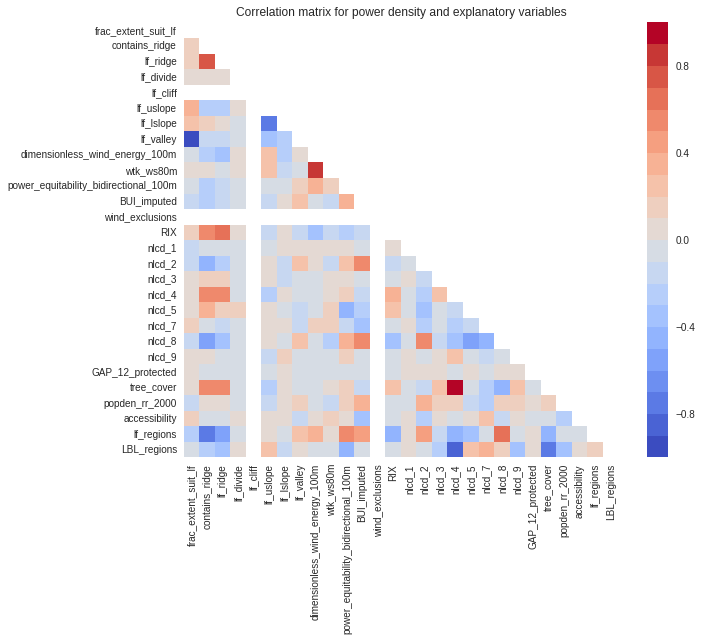

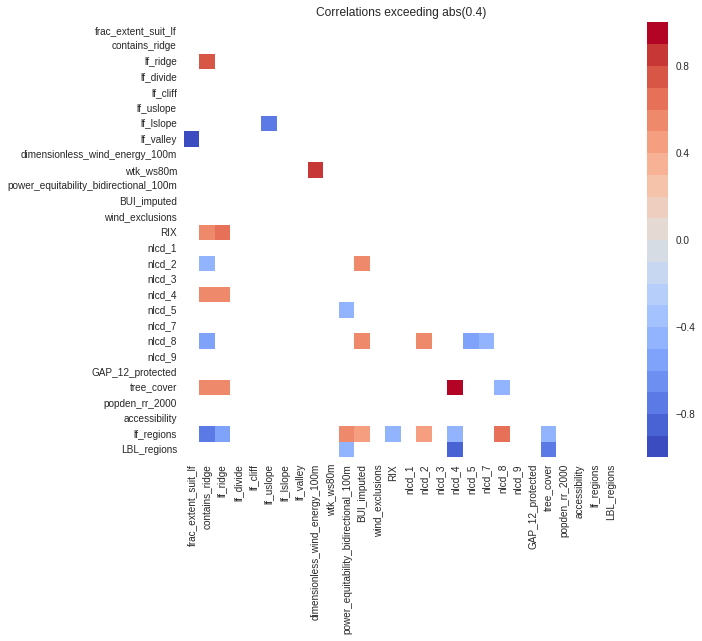

In [206]:
from matplotlib import cm as CM 

corr = dftrain.corr()

cmap = CM.get_cmap('coolwarm', 20)
cmap.set_bad('w')

fig, ax = plt.subplots(1, figsize=(10, 8))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=corr, mask=mask, cmap=cmap, square=True);
plt.title('Correlation matrix for power density and explanatory variables');
plt.show();

fig, ax = plt.subplots(1, figsize=(10, 8))
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.4)
mask2 = np.zeros_like(corr, dtype=np.bool)
mask2[np.triu_indices_from(mask2)] = True
m2 = np.ma.array(mask2, mask=m)
m2 = (m2 == 1)
sns.heatmap(data=corr, mask=m2, cmap=cmap, square=True);
plt.title('Correlations exceeding abs(0.4)');
plt.show();

## Create feature columns and input functions
The Gradient Boosting estimator can utilize both numeric and categorical features. Feature columns work with all TensorFlow estimators and their purpose is to define the features used for modeling. Additionally they provide some feature engineering capabilities like one-hot-encoding, normalization, and bucketization. In this tutorial, the fields in `CATEGORICAL_COLUMNS` are transformed from categorical columns to one-hot-encoded columns ([indicator column](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column)):

In [0]:
#@title Make and test a parsing function

def parse_tfrecord(example_proto):
  parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
  labels = parsed_features.pop(label)
  return parsed_features, tf.cast(labels, tf.float32)

In [0]:
#@title Map the function over the dataset
# parsedDataset = driveDataset.map(parse_tfrecord, num_parallel_calls=5)

# iterator = parsedDataset.make_one_shot_iterator()
# foo = iterator.get_next()
# with tf.Session() as sess:
#     print(sess.run([foo]))
    

In [0]:
def create_dataframe_from_tfrecords(tf_records_file):
  
  driveDataset = tf.data.TFRecordDataset(tf_records_file, compression_type='GZIP')
  parsedDataset = driveDataset.map(parse_tfrecord, num_parallel_calls=5)
  # Choose a value of `max_elems` that is at least as large as the dataset, otherwise will produce an error stating there are more than one elements
  max_elems = 10000
  parsedDataset = parsedDataset.batch(batch_size=max_elems)

  # Extracts the single element of a dataset as one or more `tf.Tensor` objects.
  # No iterator needed in this case!
  whole_dataset_tensors = tf.data.experimental.get_single_element(parsedDataset)

  # Create a session and evaluate `whole_dataset_tensors` to get arrays contained within a dictionary.
  with tf.Session() as sess:
    whole_dataset_arrays = sess.run(whole_dataset_tensors)
      
  # Create dictionary for input variables and their values
  raw_dict = {}

  for key in whole_dataset_arrays[0].keys():

    #Prepare data for DataFrame
    raw_dict[key] = whole_dataset_arrays[0][key].flatten().T
    raw_dict[label] = whole_dataset_arrays[1].flatten().T
    
    raw_df = pd.DataFrame.from_dict(raw_dict, orient='columns')
    
  return raw_df

In [0]:
# @title Create dataframe and summary statistics of raw input data
raw_df = create_dataframe_from_tfrecords(train_file)
n_records = raw_df.shape[0]
print('number of records in training set is: ' + str(n_records))
print(raw_df.head())

raw_describe = raw_df.describe()
print(raw_describe)

In [0]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [1]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset. 
n_batches = 1

params = {
  'n_trees': 50,
  'max_depth': 20,
    'learning_rate':0.001,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to 
  # make an initial prediction before using any features (e.g. use the mean of 
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesRegressor(columns, **params)

# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
est.train(train_input_fn, max_steps=1000)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

NameError: ignored

In [194]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))
# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['predictions'][0] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
frac_extent_suit_lf,107.0,0.012615,1.030636,-0.759321,-0.472394,-0.247406,-0.031734,4.603613
BUI_imputed,107.0,0.652364,1.959884,-0.457045,-0.283531,-0.075861,0.534410,11.787087
lf_lslope,107.0,0.075146,0.761589,-0.436285,-0.257399,-0.144373,0.144686,6.374143
accessibility,107.0,0.100926,0.468707,-0.383643,-0.189675,-0.053003,0.171441,1.714234
popden_rr_2000,107.0,-0.032952,0.369945,-0.418121,-0.231705,-0.089186,0.005849,2.045757
nlcd_2,107.0,-0.085973,0.349864,-0.491178,-0.334435,-0.162077,0.027048,1.130957
lf_uslope,107.0,-0.089376,0.383542,-0.598888,-0.321538,-0.185853,0.030019,1.714974
lf_valley,107.0,-0.041998,0.348235,-0.527695,-0.234238,-0.177304,0.010241,1.159980
nlcd_4,107.0,-0.029853,0.167973,-0.308833,-0.191303,0.030243,0.080926,0.523293
power_equitability_bidirectional_100m,107.0,0.324895,0.677897,-0.315648,-0.096525,0.049073,0.485084,3.774093


In [0]:
# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [0]:
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)
    
def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
  return ax

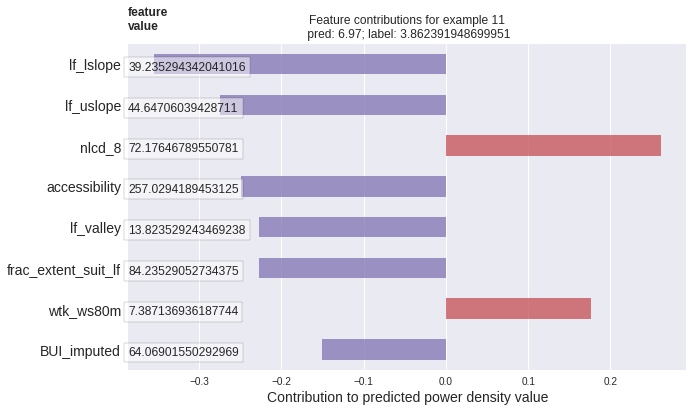

In [201]:
# Plot results.
ID = np.random.randint(1,y_eval.shape[0])
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted power density value', size=14);

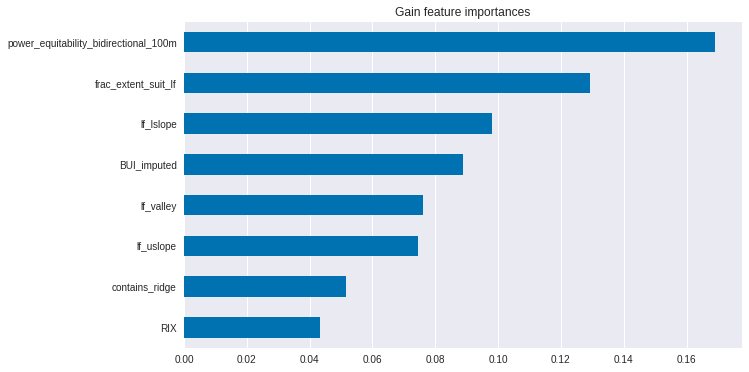

In [167]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

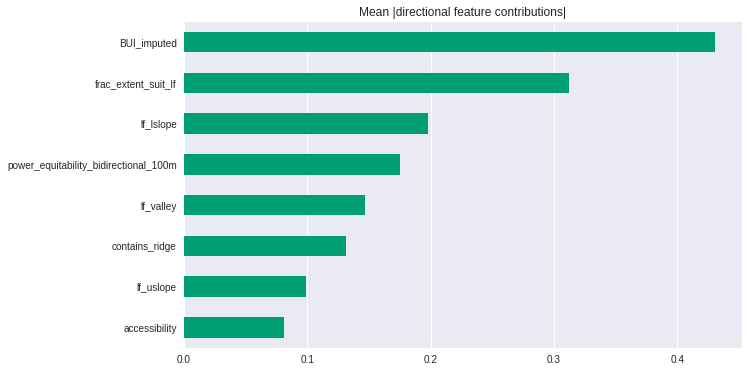

In [168]:
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

In [0]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
  # Initialize plot.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))
  
  # Create example dataframe.
  TOP_N = 8  # View top 8 features.
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-TOP_N:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')
  
  # Add contributions of entire distribution.
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)
  
  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

  # Add local contributions.
  ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')
  
  # Legend
  # Proxy plot, to show violinplot dist on legend.
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
  legend.get_frame().set_facecolor('white')
  
  # Format plot.
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted power density', size=14)

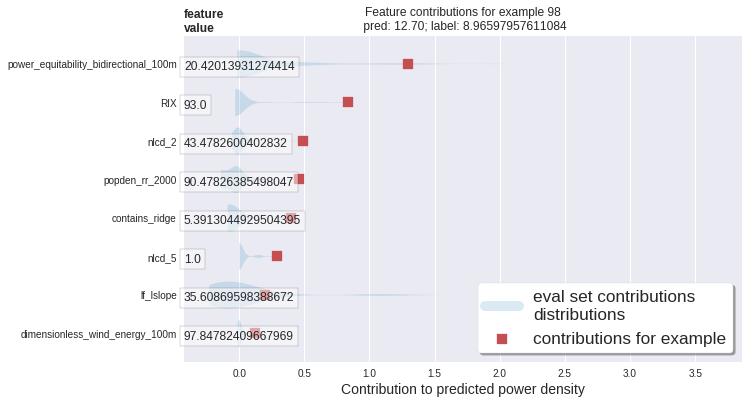

In [170]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]));

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


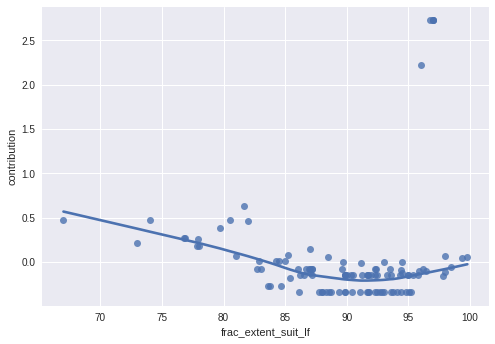

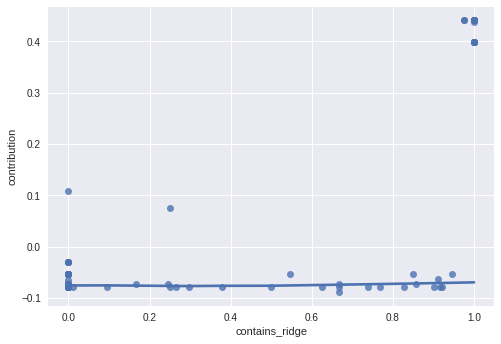

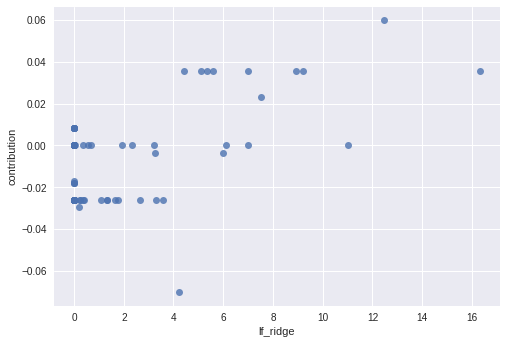

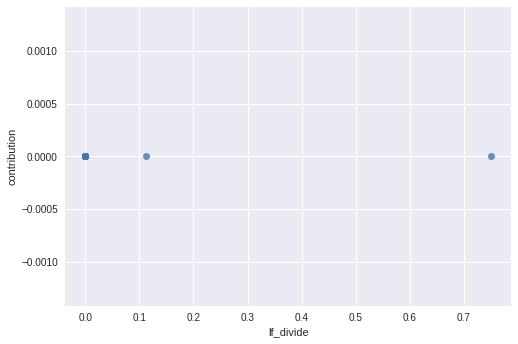

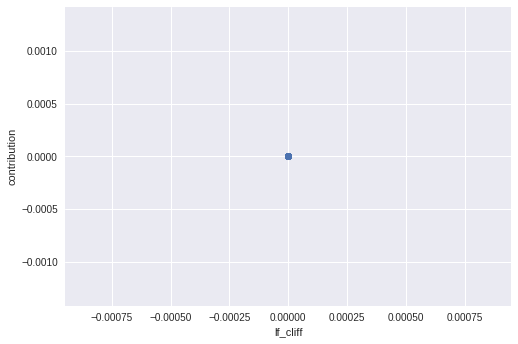

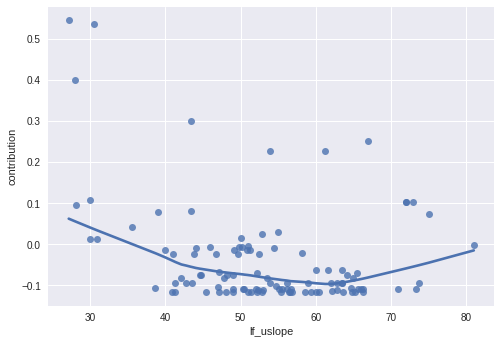

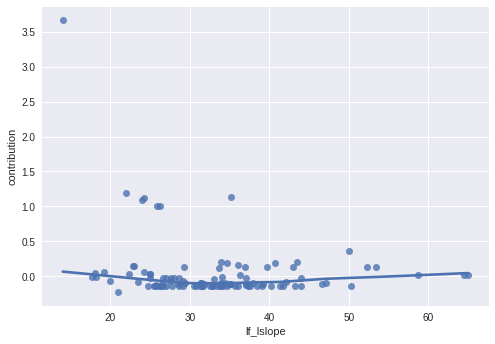

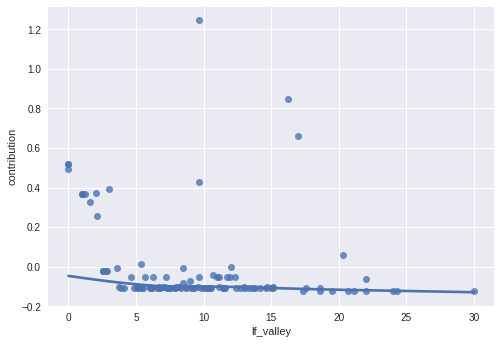

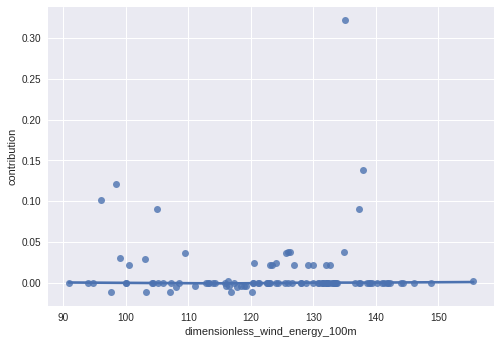

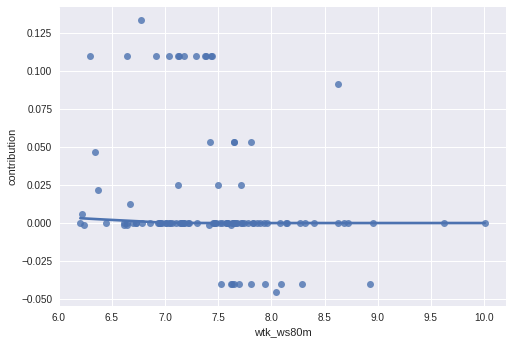

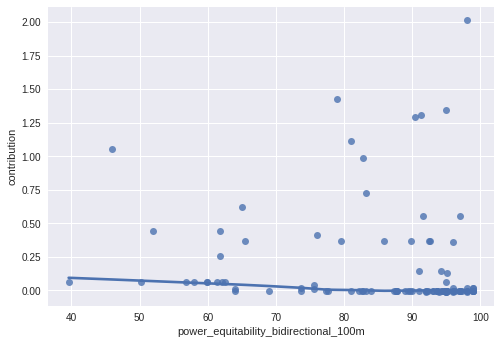

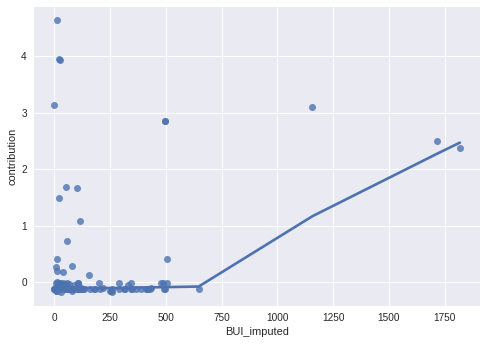

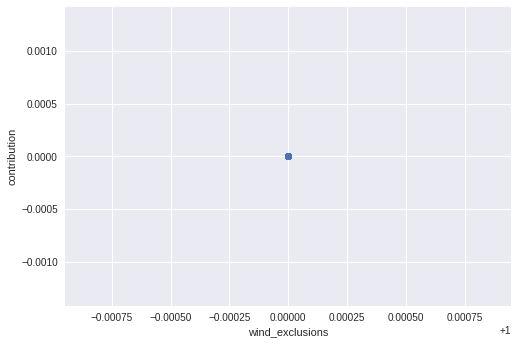

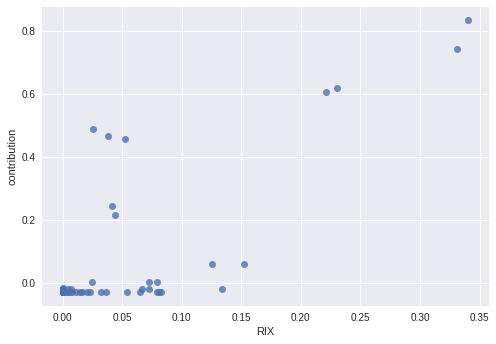

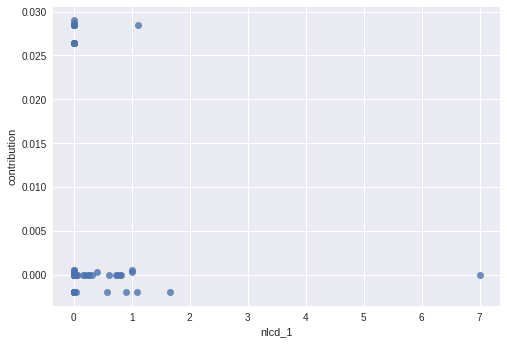

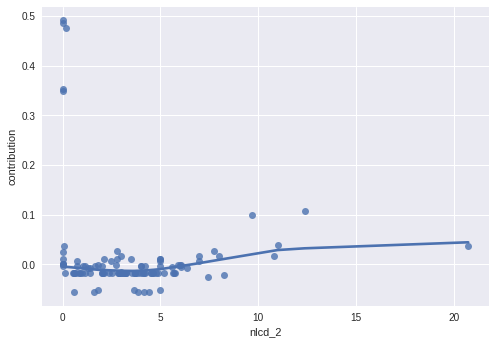

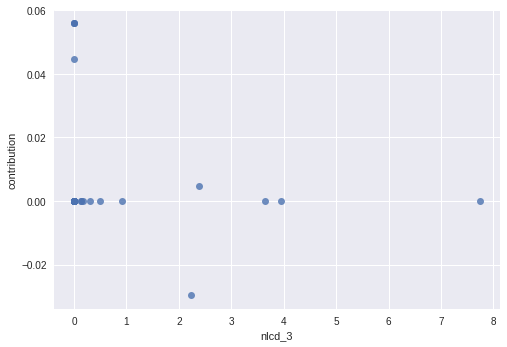

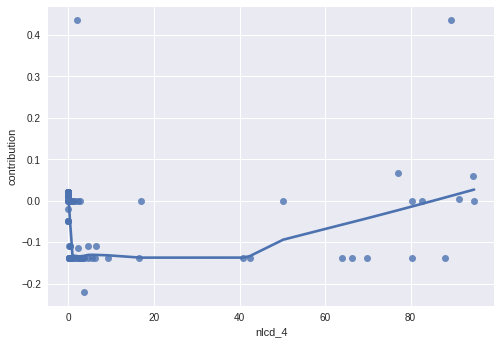

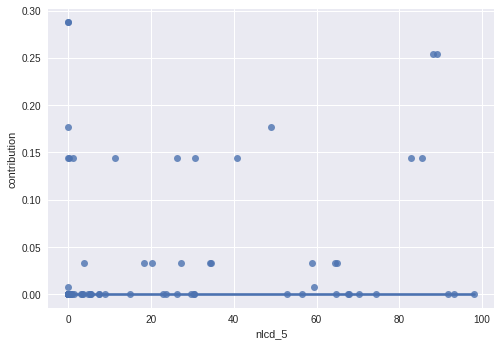

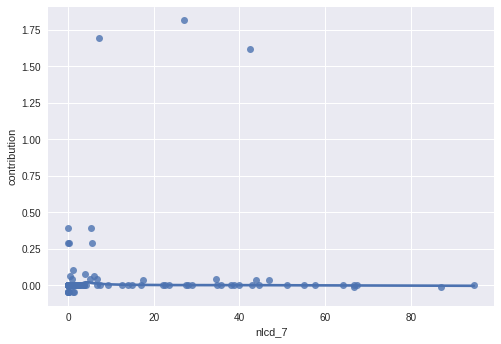

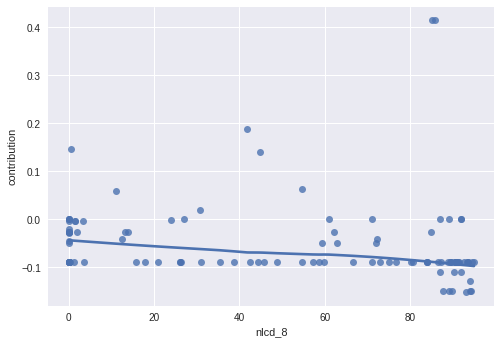

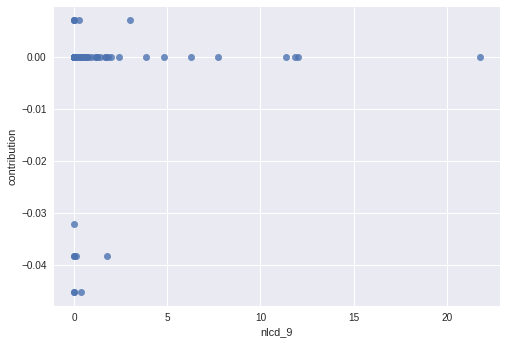

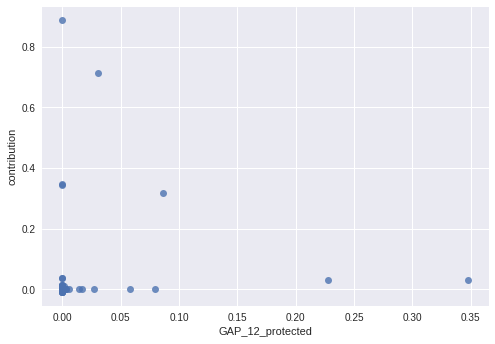

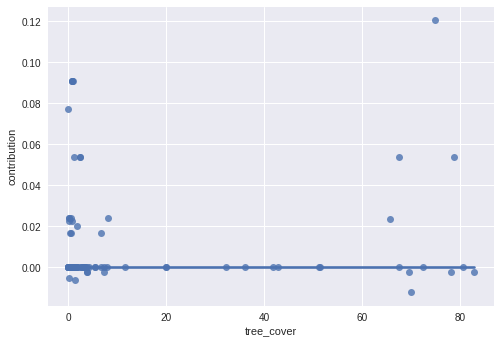

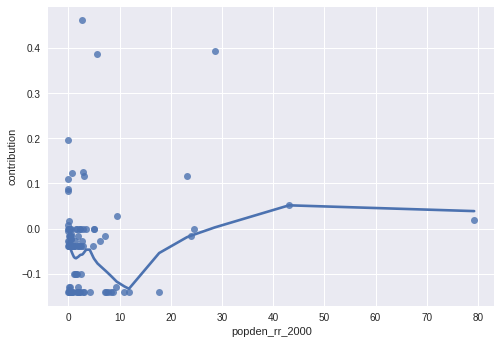

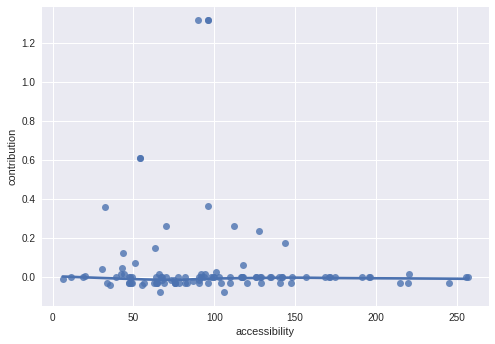

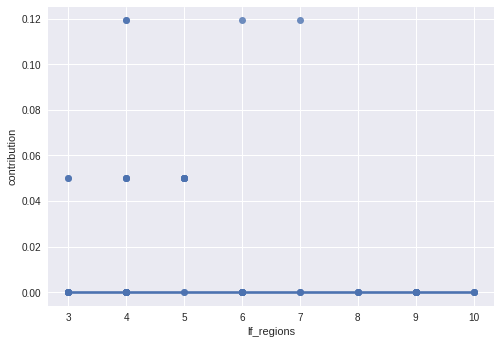

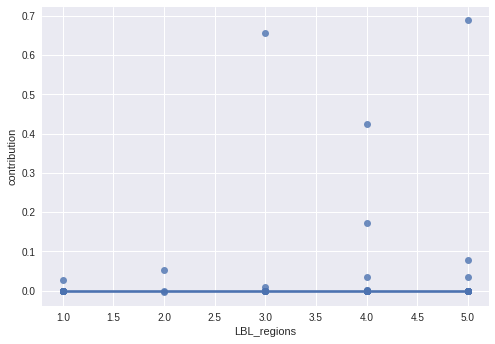

In [171]:
for FEATURE in features:
  fig, ax = plt.subplots()
  feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
  ax = sns.regplot(feature.index.values, feature.values, lowess=True);
  ax.set_ylabel('contribution')
  ax.set_xlabel(FEATURE);
  # ax.set_xlim(0, 100);

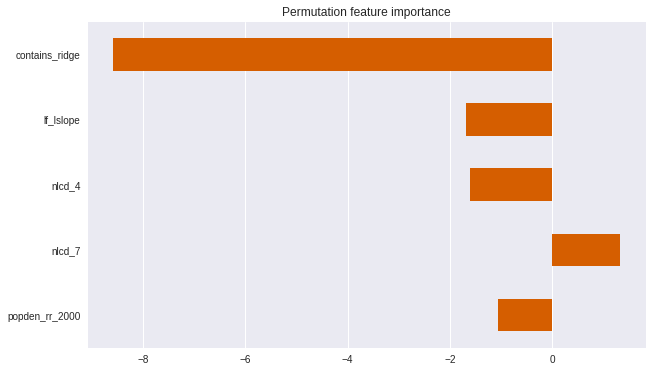

In [172]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.
    
    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['loss']

importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance');

In [0]:
def predict(est):
  """Predictions from a given estimator."""
  predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
  preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
  return preds.reshape(predict_shape)

In [0]:

df_predict = pd.concat([dfeval,y_eval], axis=1)
predict_shape = y_eval.shape

preds = pd.DataFrame({'y':y_eval, 'preds': predict(est)})

W0320 01:34:29.510355 140010944210816 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


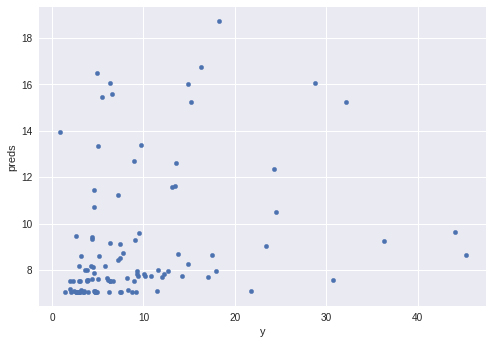

In [186]:
preds.plot('y','preds',kind='scatter')